In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rn

In [2]:
#Setup Geometry
map_factor = 10
map_size = np.array([0, 1, 0, 1])*map_factor
building1_x = np.array([.5, .5, 1, 1, 0.5])*map_factor
building1_y = np.array([.4, .6, .6, .4, 0.4])*map_factor
building2_x = np.array([0, 0, .25, .25, 0])*map_factor
building2_y = np.array([0, 1, 1, 0, 0])*map_factor
building1 = np.array([building1_x, building1_y])
building2 = np.array([building2_x, building2_y])
building_storage = np.array([building1, building2])
building_number = 2
building_height = np.ones(5,)*map_factor

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


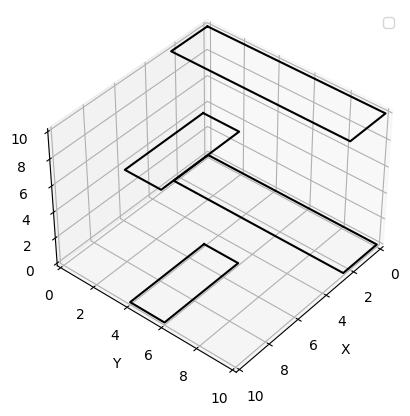

In [3]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(building1_x, building1_y, np.array([0, 0, 0, 0, 0]), '-k')
ax.plot(building1_x, building1_y, building_height, '-k')

ax.plot(building2_x, building2_y, np.array([0, 0, 0, 0, 0]), '-k')
ax.plot(building2_x, building2_y, building_height, '-k')

# Make legend, set axes limits and labels
ax.legend()
ax.set_xlim(0, map_size[1])
ax.set_ylim(0, map_size[3])
ax.set_zlim(0, map_factor)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=40., azim=40, roll=0)

plt.show()

In [4]:
# Initial Variables
x0 = np.array([8, 2, 5])
xf = np.array([6, 3, 5])
repeat = True
t_range = 0.5

In [5]:
# Sensor Setup
from Camera3D import Camera

# Camera Dictionary
cam_dict = {}
cam_dict['pos_init'] = np.array([0,0,10])
cam_dict['ang_init'] = np.array([np.pi/4, np.pi/4])

cam_dict['spec'] = {}
cam_dict['spec']['ang_limit'] = np.array([0, np.pi/2])
cam_dict['spec']['FOV'] = np.deg2rad(90)
cam_dict['spec']['range'] = 10
cam_dict['spec']['cam_time'] = np.array([10, 1])

# Build Camera
sensor_number = 1
sensor = {}

for nc in range(sensor_number):
    sensor[str(nc)] = Camera(cam_dict)

In [6]:
# Vehicle Variables
yawinit = np.deg2rad(180)
pitchinit = np.deg2rad(0)
yawrate = np.deg2rad(30)
pitchrate = np.deg2rad(30)
velocity = 2

In [7]:
# Storage
Tree = {}
Tree['x0'] = {}
Tree['xf'] = {}
Tree['x0']['Position'] = x0
Tree['x0']['Yaw'] = yawinit
Tree['x0']['Pitch'] = pitchinit
Tree['x0']['Time'] = 0
Tree['x0']['Time Cost'] = 0
Tree['x0']['Dist Cost'] = 0

In [8]:
xprev = x0
yawprev = yawinit
pitchprev = pitchinit
counter = 1
print('Node: '+ str(x0[0]) + ', ' + str(x0[1]) + ', ' + str(x0[2]))
while repeat:
    print('=================================')
    print('Counter: '+ str(counter))
    # set probability
    sample = np.array([0.5, 0.5])

    # Vehicle Sample Domain
    rn_t = rn.uniform(0, t_range)
    #rn_t = t_range

    # Randomly sample X1
    rn_select = rn.uniform(0, 1)
    nextNode = True
    while nextNode:
        if rn_select >= 0 and rn_select < sample[0]:
            print('Random Sample')
            yawcurr = yawprev+yawrate*rn_t
            pitchcurr = pitchprev + pitchrate*rn_t
            rn_yawangle = rn.uniform(0, yawcurr)
            rn_pitchangle = rn.uniform(0, pitchcurr)
            R = velocity*rn_t
            rn_x = xprev[0] + R*np.cos(rn_pitchangle)*np.cos(rn_yawangle)
            rn_y = xprev[1] + R*np.cos(rn_pitchangle)*np.sin(rn_yawangle)
            rn_z = xprev[2] + R*np.sin(rn_pitchangle)
        elif rn_select >= sample[0] and rn_select <= (sample[0] + sample[1]):
            print('To Final')
            normvec = (xf-x0)/np.linalg.norm(xf-x0, 2)
            R = velocity*rn_t
            travel = R*normvec
            rn_x = xprev[0] + travel[0]
            rn_y = xprev[1] + travel[1]
            rn_z = xprev[2] + travel[2]
        
        #print(rn_x, rn_y, rn_z)
        
        # Check if vehicle's position is valid in parallel (return 1 when valid)
        # Check1: check if it is still in map
        # check2: check if it is in any building
        # check3: check if it is in FOV of sensors
        check_vec = np.zeros(1+building_number+sensor_number,)
        

        # Check 1
        if ((rn_x >= map_size[0] and rn_x <= map_size[1])&(rn_y >= map_size[2] and rn_y <= map_size[3])&(rn_z >= 0 and rn_z <= building_height)).all:
            check_vec[0] = 1
        else:
            check_vec[0] = 0

        # Check 2
        for nb in range (building_number):
            building_i = building_storage[nb][0]
            
            # Repeat checking for building overlap
            check_vec[1+nb] = bool(not (rn_x >= building_i[0] and rn_x <= building_i[1])&(rn_y >= building_i[2] and rn_y <= building_i[3]))

        # Check 3
        for nc in range(sensor_number):
            pan_instance1 = sensor[str(nc)].get_pan_instance(5)
            conex = sensor[str(nc)].get_state()[0:3]
            conedir = sensor[str(nc)].get_direction_vec(cam_dict['ang_init'][0], cam_dict['ang_init'][1])
            p = np.array([rn_x, rn_y, rn_z])
            cone_dist = np.dot(p-conex, conedir)
            if cone_dist >= 0 and cone_dist <= sensor[str(nc)].get_h():
                cone_radius = (cone_dist / sensor[str(nc)].get_h())*sensor[str(nc)].get_radius()
                orth_dist = np.linalg.norm((p-conex)-cone_dist*conedir)
                if orth_dist < cone_radius:
                    check_vec[1+building_number+nc] = 0
                else:
                    check_vec[1+building_number+nc] = 1

        if sum(check_vec) == 1+building_number + sensor_number:
            nextNode = False
        else:
            nextNode = True
    print('Node: '+ str(rn_x) + ', ' + str(rn_y) + ', ' + str(rn_z) + ', ' + str(np.rad2deg(yawcurr)) + ', ' + str(np.rad2deg(pitchcurr)))

    # Find closest node
    x1 = np.array([rn_x, rn_y, rn_z])
    dist_storage = []
    for i in range(counter):
        node_name_to_check = 'x'+str(i)
        dx = x1 - Tree[node_name_to_check]['Position']
        dist = np.sqrt((dx[0])**2 + (dx[1])**2 + (dx[2])**2)
        dist_storage.append(dist)
    #print(dist_storage)
    min_dist_ind = np.where(dist_storage == min(dist_storage))
    prev_node_name = 'x'+str(min_dist_ind[0][0])
    print(prev_node_name)
    

    # Log Child Node
    curr_node_name = 'x'+str(counter)
    Tree[prev_node_name]['Child'] = curr_node_name
    Tree[curr_node_name] = {}
    Tree[curr_node_name]['Parent'] = prev_node_name
    Tree[curr_node_name]['Position'] = x1
    Tree[curr_node_name]['Yaw'] = yawcurr
    Tree[curr_node_name]['Pitch'] = pitchcurr
    #Tree[curr_node_name]['Time'] = Tree[prev_node_name]['Time'] + rn_t
    #Tree[curr_node_name]['Time Cost'] = Tree[prev_node_name]['Time Cost'] + rn_t
    #Tree[curr_node_name]['Dist Cost'] = Tree[prev_node_name]['Dist Cost'] + R

    #print(Tree)

    # Choose node closest to final point
    dist_storage = []
    for i in range(counter):
        node_name_to_check = 'x'+str(i)
        dx = xf - Tree[node_name_to_check]['Position']
        dist = np.sqrt((dx[0])**2 + (dx[1])**2)
        dist_storage.append(dist)
    min_dist_ind = np.where(dist_storage == min(dist_storage))
    closest_node_name = 'x'+str(min_dist_ind[0][0])

    xprev = Tree[closest_node_name]['Position']
    yawprev = Tree[closest_node_name]['Yaw']
    pitchprev = Tree[closest_node_name]['Pitch']

    # Check for destination
    tol = 0.25
    dist_diff = x1 - xf
    dist = np.sqrt(dist_diff[0]**2+dist_diff[1]**2)
    print('Distance: ' + str(dist))

    if dist <= tol:
        repeat = False
    else:
        repeat = True

    counter += 1

Node: 8, 2, 5
Counter: 1
Random Sample
Node: 8.027528510811056, 2.3287502924359416, 5.016276191749787, 184.9545317460851, 4.954531746085111
x0
Distance: 2.135754675063719
Counter: 2
Random Sample
Node: 8.086473477108107, 2.281778504122546, 5.013526600040648, 184.42588355256973, 4.4258835525697355
x1
Distance: 2.2066294858485067
Counter: 3
To Final
Node: 7.324139968003399, 2.68044456383977, 5.016276191749787, 184.42588355256973, 4.4258835525697355
x1
Distance: 1.362153563899312
Counter: 4
To Final
Node: 7.2139515837940955, 2.7355387559444218, 5.016276191749787, 184.42588355256973, 4.4258835525697355
x3
Distance: 1.2424243226062572
Counter: 5
To Final
Node: 7.28294833960255, 2.7010403780401946, 5.016276191749787, 184.42588355256973, 4.4258835525697355
x3
Distance: 1.3173204992147087
Counter: 6
To Final
Node: 6.647316185926655, 3.018856454878142, 5.016276191749787, 184.42588355256973, 4.4258835525697355
x4
Distance: 0.647590773909885
Counter: 7
Random Sample
Node: 6.906471382334736, 2.979